In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binomtest
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rc("figure", figsize=(16, 10))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [61]:
#Parametrit

years = 3
tickers = ['TNOM.HE', 'KCR.HE', 'CAPMAN.HE']
moving_avg = 21
test_frame = 251
rf_rate = 0.03

In [62]:
#Ajan asettaminen ja datan lataaminen sekä logaritmisten tuottojen laskeminen

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days= 365 * years)

data = yf.download(tickers, start= start_date, end= end_date, interval= '1d')['Adj Close']
log_returns = np.log(data/data.shift(1)).dropna()

[*********************100%***********************]  3 of 3 completed


In [69]:
#Portfolion varianssin ja kokonaistuoton laskenta liukuvista keskiarvoista

weights = np.array([1/len(tickers)] * len(tickers))
historical_returns = (log_returns * weights).sum(axis= 1)
rolling_means = historical_returns.rolling(window= moving_avg).mean().dropna()
rolling_cov_matrices = log_returns.rolling(window= moving_avg).cov().dropna()

#For -silmukka liukuvien kovarianssien ryhmittelyyn

cov_matrices = []

for i in range(0, len(rolling_cov_matrices), 3):
    group = rolling_cov_matrices.iloc[i:i+3]
    group_df = pd.DataFrame(group.to_numpy())
    cov_matrices.append(group_df)

#Portfolion varianssien laskenta kunakin ajanhetkellä

portfolio_std_dev = []
n_sims = []

for matrix in cov_matrices:
    std_dev = np.sqrt(weights.T @ matrix @ weights)
    n = ((2.575829 * np.sqrt(weights.T @ (matrix * 252) @ weights))  / 0.01) ** 2   #tarvittavien simulaatioiden määrän määrittely
    portfolio_std_dev.append(std_dev)
    n_sims.append(n)

portfolio_std_dev_series = pd.Series(portfolio_std_dev, index=rolling_means.index)

simulations = int(round(np.sort(n_sims)[-1]))   #Simulaatiomäärä, jota käytetään kaikkiin simulaatioihin

In [64]:
#Geometrisen Brownin liikkeen laskeminen kunakin ajanhetkellä variansseilla ja kokonaistuotolla parametrisoituna

rfr = rf_rate
time = moving_avg
vol = portfolio_std_dev
S0 = 1

GBM_sims = []

#Simuloidut portfolion tuotot

for i in range(len(rolling_means)):
    simulation = n_sims[i]
    d = rolling_means[i]
    a = vol[i]
    r = np.random.normal(0, 1, (simulations, 1))
    GBM_returns = S0 * np.exp(d + a * r) - 1
    GBM_sims.append(GBM_returns)

GBM_arr = np.array(GBM_sims).reshape(len(rolling_means), simulations)

In [65]:
#VaR:n laskeminen ja taulukointi DataFrameksi

VaRs = pd.DataFrame(columns=['99 % VaR', '95 % VaR', '90 % VaR'])

for j in range(len(GBM_arr)):
    VaR1 = -np.percentile(GBM_arr[j], 100 * (1 - 0.99))
    VaR2 = -np.percentile(GBM_arr[j], 100 * (1 - 0.95))
    VaR3 = -np.percentile(GBM_arr[j], 100 * (1 - 0.90))
    VaR_df = pd.DataFrame({'99 % VaR': [VaR1], '95 % VaR': [VaR2], '90 % VaR': [VaR3]})
    VaRs = pd.concat([VaRs, VaR_df], ignore_index=True)

VaRs.set_index(portfolio_std_dev_series.index, inplace=True)
VaRs = pd.DataFrame(VaRs).tail(test_frame)

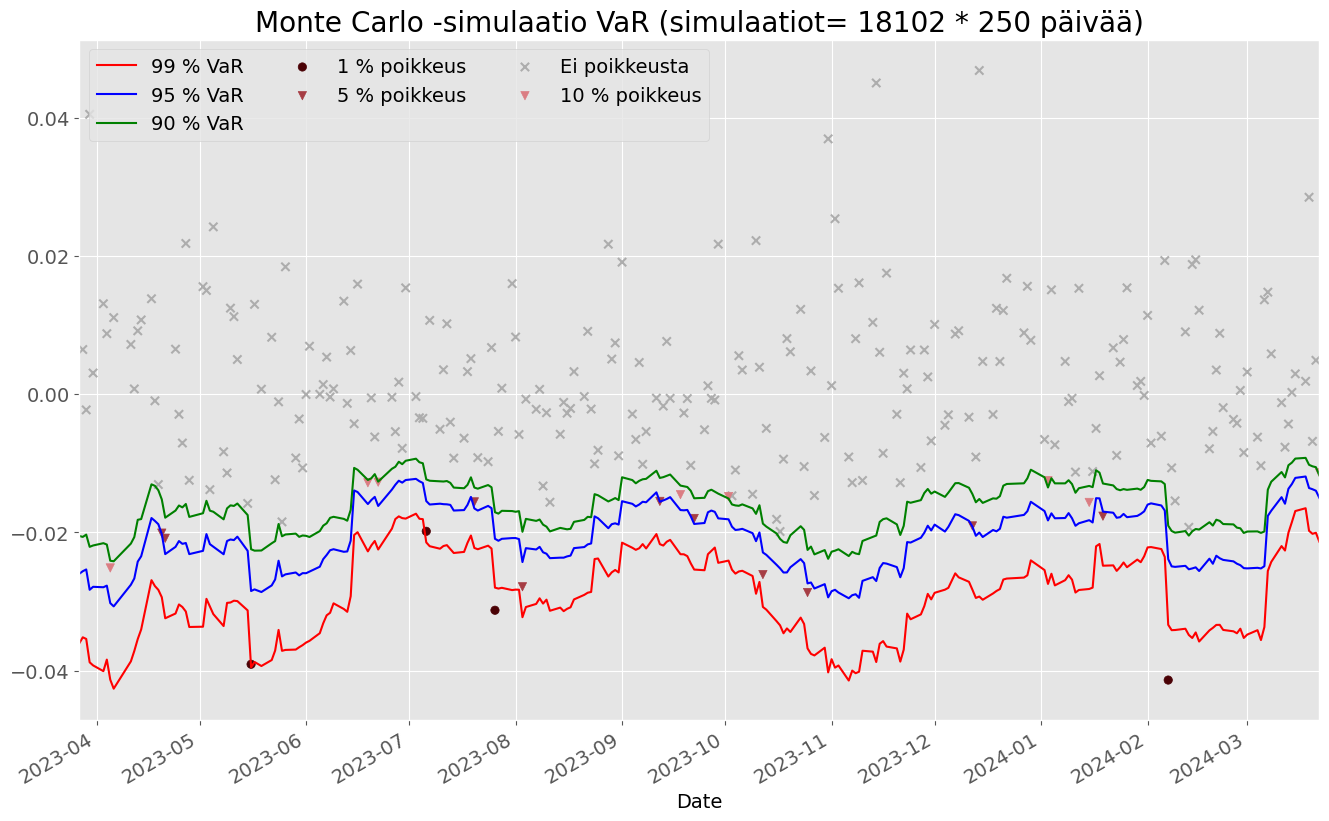

In [73]:
#Alkuperäinen plottauksen koodi, jota vahvasti muokattu: Kevin Sheppard (2021, March 3). bashtage/arch: Release 4.18 (Version v4.18). Zenodo. https://doi.org/10.5281/zenodo.593254
#VaR:n plottaus todellisia historiallisia portfolion tuottoja vastaan

value_at_risk = -VaRs
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
returns = historical_returns.tail(test_frame).copy()

#VaR aikasarjan yhden päivän viiveen asettaminen ja aikasarjojen indeksointi uudelleen

returns = returns[1:]
value_at_risk = value_at_risk[:-1]
value_at_risk.set_index(returns.index, inplace= True)

returns.name = "Stock returns"
c = []
for idx in value_at_risk.index:
    if returns[idx] < value_at_risk.loc[idx, "90 % VaR"] and returns[idx] > value_at_risk.loc[idx, "95 % VaR"]:
        c.append("#db7d83")
    elif returns[idx] > value_at_risk.loc[idx, "95 % VaR"]:
        c.append("#adadad")
    elif returns.loc[idx] < value_at_risk.loc[idx, "99 % VaR"]:
        c.append("#4a0105")
    else:
        c.append("#a63d44")
c = np.array(c, dtype="object")
labels = {
    "#4a0105": "1 % poikkeus",
    "#a63d44": "5 % poikkeus",
    "#db7d83": "10 % poikkeus",
    "#adadad": "Ei poikkeusta",
    }
markers = {"#4a0105": "o", "#a63d44": "v", "#adadad": "x", "#db7d83": "v"}
for color in np.unique(c):
    sel = np.array([value == color for value in c])
    ax.scatter(
        returns.index[sel],
        returns.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title(f"Monte Carlo -simulaatio VaR (simulaatiot= {simulations} * 250 päivää)")
leg = ax.legend(frameon=True, ncol=3)

leg_colors = ['r', 'b', 'g']
for i, text in enumerate(leg.get_lines()):
    text.set_color(leg_colors[i])

line_obj1 = plt.gca().get_lines()[0]
line_obj2 = plt.gca().get_lines()[1]
line_obj3 = plt.gca().get_lines()[2]

plt.setp(line_obj1, color="r")
plt.setp(line_obj2, color="b")
plt.setp(line_obj3, color="g")

plt.show()

In [67]:
#Z-testi suhteellisille osuuksille
#1 % ylittävien poikkeuksien kerääminen For -silmukalla

exceptions = []
for idx in value_at_risk.index:
    if returns[idx] < value_at_risk.loc[idx, "99 % VaR"]:
        exceptions.append(returns[idx])

#Testin parametrit. "expected_probability" -muuttuja on alustettu liukuluvulla 0.04,  
#joka vastaa 10 poikkeusta 250 päivän testijoukosta (0.04 * 250 = 10)

observed_successes = len(exceptions)
total_trials = len(value_at_risk)
expected_probability = 0.04

#Varsinainen testi

p_value = binomtest(k= observed_successes, n=total_trials, p=expected_probability, alternative= "less")
print(p_value)

BinomTestResult(k=4, n=250, alternative='less', statistic=0.016, pvalue=0.027002704244551888)


In [68]:
#VaR:n ja negatiivisten tuottojen korrelaatio

df = pd.concat([value_at_risk["99 % VaR"], returns], axis= 1)
df = df.drop(df.index[df['Stock returns'] > 0])
corr = df.corr()
corr

,99 % VaR,Stock returns
99 % VaR,1.000000,0.059172
Stock returns,0.059172,1.000000
